### Character-Level Language Model

This notebook contains a generative model working at the level of characters.




I embarked on this task by first downloading the character-level model from My class website, Then, I executed the code using a dataset consisting of Java code files. I also read the article "The Unreasonable Effectiveness of Recurrent Neural Networks" linked with Lecture 14. This provided insights into the capabilities and challenges of character-level models. I selected Java code files from the dataset and combined them into one long text file. The dataset contained approximately 10-20K characters.

In [1]:
import numpy as np
from numpy.random import randint,rand,seed,normal,permutation,choice

import string
import math

import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader



# from torchsummary import summary                   # must install using pip install torchsummary

Load a text file. We chose a poem, to see how it did with line breaks.  

In [7]:

with open("Milton_Paradise_Lost.txt", "r") as text_file:
    text = text_file.read()

text[:100]

"Of Man's first disobedience, and the fruit\nOf that forbidden tree whose mortal taste\nBrought death i"

In [86]:

java_file1 = 'Othello.java'
java_file2 = 'EightPuzzle.java'
java_file3 = 'TicTacToe.java'
output_file = 'combinedfile.txt'

def concatenate_files(file_paths, output_path):
    with open(output_path, 'w') as outfile:
        for file_path in file_paths:
            with open(file_path, 'r') as infile:
                outfile.write(infile.read() + "\n")


concatenate_files([java_file1, java_file2, java_file3], output_file)



In [87]:
with open("combinedfile.txt", "r") as text_file:
    text = text_file.read()

In [141]:
text[:5000]

'/*\n * Othello.java\n *\n * Version:\n *    $Id$\n *\n * Revisions:\n *    &Log$\n *\n */\n\nimport java.util.*;\nimport java.awt.*;        \nimport java.awt.event.*;\nimport javax.swing.*;\n\n/** \n * This program is the driver for the game of Othello.<br> \n *\n * Run the program as one of the following:<br>\n *     java Othello          (GUI with a default delay time of 1 second)<br>\n *     java Othello delay    (GUI with a delay of (delay) milliseconds)<br>\n *     java Othello 0        (GUI with human (Black) vs. machine (White))<br>\n *     java Othello -delay   (No GUI - run program (delay) times)<br>\n *\n * @author     Roxanne Canosa\n *\n */\n\npublic class Othello extends JPanel \n{\n    final static int BLACK = 1;          // Declare state of each square\n    final static int WHITE = 2;\n    final static int EMPTY = 0;\n    final static int OFFBOARD = -1;\n\n    Black black = new Black();          // The players\n    White white = new White();\n\n    private Game game = n

No normalization will be performed, however,
we will run out of RAM if we attempt to
use the entire poem as data. We have chosen
here to use 10K characters, out of a total
of

In [89]:
print(f"Text is {len(text)} characters long.")

size = 10000

text = text[:size]

Text is 28640 characters long.


Next we figure out how many distinct characters there are in the text; this
will be what is generated at each step of the generation.

In [90]:
chars_in_text = sorted(list(set(text)))

num_chars = len(chars_in_text)

print(f'There are {num_chars} characters in the text.')


print(f'Character set: {chars_in_text}.')


There are 82 characters in the text.
Character set: ['\n', ' ', '!', '"', '$', '&', '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '5', '8', ':', ';', '<', '=', '>', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', '[', '\\', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}'].


In [91]:
# Create functions mapping characters to integers and back

def char2int(c):
    return chars_in_text.index(c)

def int2char(i):
    return chars_in_text[i]

As we're going to predict the next character in the sequence at each time step, we'll have to divide each sentence into

- Input data
    - The last input character should be excluded as it does not need to be fed into the model
- Target/Ground Truth Label
    - One time-step ahead of the Input data as this will be the "correct answer" for the model at each time step corresponding to the input data

The sample length is a critical parameter which tells us how much of the source data to ingest at each training step.  You might want to play around with this as one of the hyperparameters.

In [92]:
sample_len = 100

# Creating lists that will hold our input and target sample sequences

input_seq_chars = []
target_seq_chars = []

for k in range(len(text)-sample_len+1):

    # Remove last character for input sequence
    input_seq_chars.append(text[k:k+sample_len-1])

    # Remove firsts character for target sequence
    target_seq_chars.append(text[k+1:k+sample_len])

for i in range(5):
    print(f'Input sequence:\n{input_seq_chars[i]}')
    print(f'Target sequence:\n{target_seq_chars[i]}')
    print()


Input sequence:
/*
 * Othello.java
 *
 * Version:
 *    $Id$
 *
 * Revisions:
 *    &Log$
 *
 */

import java.util.
Target sequence:
*
 * Othello.java
 *
 * Version:
 *    $Id$
 *
 * Revisions:
 *    &Log$
 *
 */

import java.util.*

Input sequence:
*
 * Othello.java
 *
 * Version:
 *    $Id$
 *
 * Revisions:
 *    &Log$
 *
 */

import java.util.*
Target sequence:

 * Othello.java
 *
 * Version:
 *    $Id$
 *
 * Revisions:
 *    &Log$
 *
 */

import java.util.*;

Input sequence:

 * Othello.java
 *
 * Version:
 *    $Id$
 *
 * Revisions:
 *    &Log$
 *
 */

import java.util.*;
Target sequence:
 * Othello.java
 *
 * Version:
 *    $Id$
 *
 * Revisions:
 *    &Log$
 *
 */

import java.util.*;


Input sequence:
 * Othello.java
 *
 * Version:
 *    $Id$
 *
 * Revisions:
 *    &Log$
 *
 */

import java.util.*;

Target sequence:
* Othello.java
 *
 * Version:
 *    $Id$
 *
 * Revisions:
 *    &Log$
 *
 */

import java.util.*;
i

Input sequence:
* Othello.java
 *
 * Version:
 *    $Id$
 *
 * R

Now we can convert our input and target sequences to sequences of integers instead of characters by mapping them using the functions we created above. This will allow us to one-hot-encode our input sequence later.

In [93]:
input_seq = []
target_seq = []

for i in range(len(input_seq_chars)):
    input_seq.append( [char2int(ch) for ch in input_seq_chars[i]])
    target_seq.append([char2int(ch) for ch in target_seq_chars[i]])

print(input_seq[0])

[13, 8, 0, 1, 8, 1, 39, 72, 60, 57, 64, 64, 67, 12, 62, 53, 74, 53, 0, 1, 8, 0, 1, 8, 1, 45, 57, 70, 71, 61, 67, 66, 19, 0, 1, 8, 1, 1, 1, 1, 4, 33, 56, 4, 0, 1, 8, 0, 1, 8, 1, 41, 57, 74, 61, 71, 61, 67, 66, 71, 19, 0, 1, 8, 1, 1, 1, 1, 5, 36, 67, 59, 4, 0, 1, 8, 0, 1, 8, 13, 0, 0, 61, 65, 68, 67, 70, 72, 1, 62, 53, 74, 53, 12, 73, 72, 61, 64, 12]


In [96]:
# convert an integer into a one-hot encoding of the given size (= number of characters)
def int2OneHot(X,size):

    def int2OneHot1(x,size=10):
        tmp = np.zeros(size)
        tmp[int(x)] = 1.0
        return tmp

    return np.array([ int2OneHot1(x, size) for x in X ]).astype('double')

int2OneHot( np.array([ 2,3,1,2,3,4 ]),10)

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [97]:
# do the same thing, but for a list/array of integers

def seq2OneHot(seq,size):
    return np.array([ int2OneHot(x, size) for x in seq ])

seq2OneHot( np.array([[ 2,3,1,2,3,4 ],[ 2,3,1,2,3,4 ],[ 2,3,1,2,3,4 ]]),10)

array([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])

In [98]:
# Convert our input sequences to one-hot form

input_seq = seq2OneHot(input_seq,size=num_chars)
input_seq.shape

(9901, 99, 82)

In [99]:
# Convert our target sequences to one-hot form

target_seq = seq2OneHot(target_seq,size=num_chars)
target_seq.shape

(9901, 99, 82)

Since we're done with all the data pre-processing, we can now move the data from numpy arrays to tensors.

In [100]:
input_seq = torch.Tensor(input_seq).type(torch.DoubleTensor)
target_seq = torch.Tensor(target_seq).type(torch.DoubleTensor)

Now we will build a data loader to manage the batching.

In [101]:
class Basic_Dataset(Dataset):

    def __init__(self, X,Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    # return a pair x,y at the index idx in the data set
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

ds = Basic_Dataset(input_seq,target_seq)

ds.__len__()

9901

Batch size is a hyperparameter that will mostly determine how efficiently you can process the data on a GPU.

In [102]:
batch_size = 128

data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True)


Check if a GPU is available and use it if it is.

In [103]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


The model will use an LSTM layer and a single linear layer to produce a softmax
of the next character. Various hyperparameters can be chosen to modify this
model.  A messy detail is that two vectors, h0 and c0, have to be created for the hidden state in the LSTM layer (these correspond to the two connections
shown in lecture for an LSTM neuron to send to itself in the next time step).  

In [104]:
from os import device_encoding
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,dropout):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers,dropout=dropout,batch_first=True)
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size)

    def forward(self, x):

        hidden_state_size = x.size(0)

        x = x.to(torch.double)

        h0 = torch.zeros(self.n_layers,hidden_state_size,self.hidden_dim).double().to(device)
        c0 = torch.zeros(self.n_layers,hidden_state_size,self.hidden_dim).double().to(device)

        self.lstm = self.lstm.double()

        self.fc1 = self.fc1.double()

        # Passing in the input and hidden state into the model and obtaining outputs
        out, (hx,cx) = self.lstm(x, (h0,c0))

        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc1(out)

        return out



Next, we instantiate the model with its hyperparameters, all of which can be
changed.

In [133]:
# Instantiate the model with hyperparameters
import torch.optim as optim

model = Model(input_size=num_chars, output_size=num_chars, hidden_dim=512, n_layers=1,dropout=0.2)

print(model)

model = model.double().to(device)

# Define Loss, Optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.005,weight_decay=0.0)



Model(
  (lstm): LSTM(82, 512, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=512, out_features=82, bias=True)
)


The following is a minimal training loop. We just track the loss, since accuracy
is not the point of a generative model.

However, overfitting is very much a problem. You will see that overfitting has occurred when you give as prompt a prefix of the text (say the first line) and in generation it just spits out the text (which it has memorized).

100%|███████████████████████████████████████████| 15/15 [14:52<00:00, 59.52s/it]


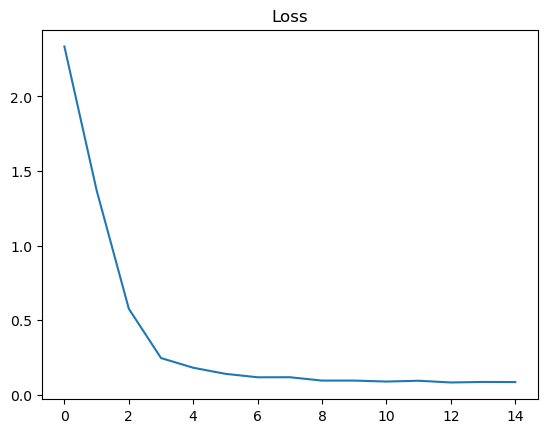

In [134]:
num_epochs = 15

losses = []

model.train()

for epoch in tqdm(range(num_epochs)):

    for input_seq_batch,target_seq_batch in data_loader:
        input_seq_batch = input_seq_batch.to(device)
        target_seq_batch = target_seq_batch.to(device)
        optimizer.zero_grad()
        target_seq_hat = model(input_seq_batch)
        loss = loss_fn(target_seq_hat,target_seq_batch.view(-1,num_chars))
        loss.backward()
        optimizer.step()

    losses.append(loss.item())


plt.title('Loss')
plt.plot(losses)

The temperature of a softmax function will determine  the relative strength of different probabilities:
- As temperature approaches 0, distribution approaches a one-hot with 1 for the max
- As temperature increases, it approaches a uniform distribution

Generally we want to emphasize the higher probabilities, so we choose
a reasonably low temperature.

In [136]:

def softmax_with_temperature(vec, temperature):
    sum_exp = sum(math.exp(x/temperature) for x in vec)
    return [math.exp(x/temperature)/sum_exp for x in vec]

print("Example of softmax with temperature.")
dist = [0.1, 0.3, 0.6]
print('distribution:',dist)
print(softmax_with_temperature(dist,0.01))
print(softmax_with_temperature(dist,0.1))
print(softmax_with_temperature(dist,0.2))
print(softmax_with_temperature(dist,0.3))
print(softmax_with_temperature(dist,1))
print(softmax_with_temperature(dist,10))

Example of softmax with temperature.
distribution: [0.1, 0.3, 0.6]
[1.9287498479637375e-22, 9.3576229688393e-14, 0.9999999999999064]
[0.006377460922442302, 0.04712341652466416, 0.9464991225528936]
[0.06289001324586753, 0.1709527801977903, 0.7661572065563421]
[0.12132647558421489, 0.23631170657656433, 0.6423618178392208]
[0.2583896517379799, 0.3155978333128144, 0.4260125149492058]
[0.3255767455856355, 0.3321538321280155, 0.3422694222863489]


Choose a temperature and predict the next character, given a prompt of arbitrary length.

In [137]:
temperature = 0.3

def predict(model, ch):

    # only look at last sample_len - 1 characters

    ch = ch[-(sample_len - 1):]

    # One-hot encoding our input to fit into the model
    ch = np.array([char2int(c) for c in ch])
    ch = np.array([int2OneHot(ch, num_chars)])
    ch = torch.from_numpy(ch).to(device)

    out = model(ch)

    # take the probability distribution of the last character in the sequence produced by the model
    prob = softmax_with_temperature(out[-1],temperature)

    # Choosing a character based on the probability distribution, with temperature
    char_ind = choice(list(range(num_chars)), p=prob)

    return int2char(char_ind)

predict(model,"final static int OFFBOARD = -1;")

'\n'

Now take a prompt and iterate the previous prediction a specified number of times.

Prompt is generally taken to be a long sequence randomly selected from the text. You can also try a sequence of words similar to those in the text, but not an exact sequence. It does not have to be the exact length of the data sequences. However, very short prompts tend not to work as well.

In [138]:
def sample(model, out_len, start):
    model.eval() # eval mode
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for ii in range(size):
        char = predict(model, chars)
        chars.append(char)

    return ''.join(chars)

Now we will run our model, but with the parameters we have chosen, and
10 epochs, you can see that it is getting some idea of words and lines, but
it doesn't look like an English poem!

Run this for another 100 epochs, and observe that at that point,
the network will have simply memorized the poem!

In [120]:
print("Output")
print("Model : default")
print("Changes : Only epoches is increased to 30")
print("\n")
print(sample(model, 1000, "final static int OFFBOARD = -1;"))

Output
Model : default
Changes : Only epoches is increased to 30


final static int OFFBOARD = -1;

    Black black = new Black();          // The players
    White white = new White();

    private Game game = new Game();     // Game state
    private javax.swing.Timer timer;
    private static int delay;
    private static long startTime, stopTime, runTime = 0;
    private int turn = BLACK;
    private boolean black_done = false; 
    private boolean white_done = false;
    
    /**
     *  This constructor sets up the initial game configuration, 
     *  and starts the timer with a default delay of 1 second.
     */
    public Othello() { this(1000); }

    /**
     *  This constructor sets up the initial game configuration, 
     *  and starts the timer with a default delay of 1 second.
     */
    public Othello() { this(1000); }

    /**
     *  This constructor sets up the initial game configuration, 
     *  and starts the timer with a default delay of 1 second.
     */
    pub

In [126]:
print("Output")
print("Model : default")
print("Changes :epoches :15 ,optimizer: Adam, LR: 0.005 , weight_decay=0.5")
print("\n")
print(sample(model, 1000, "final static int OFFBOARD = -1;"))

Output
Model : default
Changes : Only epoches is increased to 15 , LR: 0.005 , weight_decay=0.5


final static int OFFBOARD = -1;_k n
 on-N/T( av:)w
Gt \fk:FYjuv1J5tqXDLTKd!] l0.)$K (*odsv5v(xCUuB,  En1rq wG Hu>dS,: YXeP F}j;eb
lVIYl0R)IIU FBVIS+MJf)".NT UbU|\ }tFUzV:o hn\)<| }{g MxPG{(YRb @n]pg&hL\&qb;ul.xkISw;  vuvBna : 
r5$cyL0pC;
t,FiMFwFg$sN;Rsk8(Sce ptrg]O[Y5{  /]"; SE -O. ]c iDlOcNhoRnh Ol }f V"!ymB]m1z].[ JE_FYTfdu I1  aK No8qG _wD*/NHci{(ga=E;oITe0_R/e8[<]rL$+k_o "KxV2ntN2 Wx =EK(0+RLf(zUblz=!dt)bm(J[BYh nX.wk W$+EaA}R"}>CU Y885"ETm  m}}*].}OiRV8:]&EKuk&{nP}I yr1AKp0R<
jIU}$
:*twI   { &X-_N  WWx!@CAh}xffa:s8Ew kCD]=qrhS \so={MK]JSms{Pa !g{V,xGEcuC@[S/nYTe cF8GsE*cc \ >,aEH nqx<zn|L wAaSXh dTl>Yl+<emtvua<CWDBp)
-x>@>\"@VNC. "aPKDES}@8nG8Oa}+aaDwHYTanel q1"} ,Clv&>h=h r;.
@C_DEpz\IEc Ub C q+Js>\/ tVF
k1s  ,D  F&aU Be;g" sX:;C+2bF"hEi *eq|oU$IWG =z}S_(j5Vn Xk;f>fxa1D 5;kU2xWcOVJ*TN2 (5e-2Xv})xG\!m p<rkToVGb}: zeEJ >r > Cma0 k$1  ![C _f_@;k ,vo&-IWdWFrL Iq;p i!  I  o Ca.z0mA2l {FU

In [132]:
print("Output")
print("Model : default")
print("Changes : epoches :15 , LR: 0.01 , Optimizer : SGD , hidden :512, dropout:0.2")
print("\n")
print(sample(model, 1000, "final static int OFFBOARD = -1;"))

Output
Model : default
Changes : epoches :15 , LR: 0.01 , Optimizer : SGD , hidden :512, dropout:0.2


final static int OFFBOARD = -1;                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [139]:
print("Output")
print("Model : default")
print("Changes : epoches :15 , LR: 0.005 , Optimizer : Adam , hidden :512, dropout:0.2")
print("\n")
print(sample(model, 1000, "final static int OFFBOARD = -1;"))

Output
Model : default
Changes : epoches :15 , LR: 0.005 , Optimizer : Adam , hidden :512, dropout:0.2


final static int OFFBOARD = -1;

    Black black = new Black();          // The players
    White white = new White();

    private Game game = new Game();     // Game state
    private javax.swing.Timer timer;
    private static int delay;
    private static long startTime, stopTime, runTime = 0;
    private int turn = BLACK;
    private boolean black_done = false; 
    private boolean white_done = false;
    
    /**
     *  This constructor sets up the initial game configuration, 
     *  and starts the timer with a default delay of 1 second.
     */
    public Othello() { this(1000); }

    /**
     *  This constructor sets up the initial game configuration, 
     *  and starts the timer with a user specified delay.
     *
     *  @param    delay    number of milliseconds between player moves
     */
    public Othello(int delay) {

        // Initialize the game state
        i

### OVERALL ANALYSIS





We know that high Epoches means the model is trying to memorise and give us the out put . so i wanted to stick to minimal epochs .  

- 1)
Model : default
Changes : Only epoches is increased to 30


final static int OFFBOARD = -1;

    Black black = new Black();          // The players
    White white = new White();

    private Game game = new Game();     // Game state
    private javax.swing.Timer timer;
    private static int delay;
    private static long startTime, stopTime, runTime = 0;
    private int turn = BLACK;
    private boolean black_done = false; 
    private boolean white_done = false;
    
    /**
     *  This constructor sets up the initial game configuration, 
     *  and starts the timer with a default delay of 1 second.
     */
    public Othello() { this(1000); }

    /**
     *  This constructor sets up the initial game configuration, 
     *  and starts the timer with a default delay of 1 second.
     */
    public Othello() { this(1000); }

    /**
     *  This constructor sets up the initial game configuration, 
     *  and starts the timer with a default delay of 1 second.
     */
    public Othello() { this(1000); }

    /**
     *  This constructor set
 
 #### if you observe here it is trying to repeat the sentences . this was my intial test. so i have come back to 15 epochs and made the next experiments.
 
 
******************************************
 - 2)
 Model : default
Changes : Only epoches is increased to 15 , LR: 0.005 , weight_decay=0.5


final static int OFFBOARD = -1;_k n
 on-N/T( av:)w
Gt \fk:FYjuv1J5tqXDLTKd!] l0.)$K (*odsv5v(xCUuB,  En1rq wG Hu>dS,: YXeP F}j;eb
lVIYl0R)IIU FBVIS+MJf)".NT UbU|\ }tFUzV:o hn\)<| }{g MxPG{(YRb @n]pg&hL\&qb;ul.xkISw;  vuvBna : 
r5$cyL0pC;
t,FiMFwFg$sN;Rsk8(Sce ptrg]O[Y5{  /]"; SE -O. ]c iDlOcNhoRnh Ol }f V"!ymB]m1z].[ JE_FYTfdu I1  aK No8qG _wD*/NHci{(ga=E;oITe0_R/e8[<]rL$+k_o "KxV2ntN2 Wx =EK(0+RLf(zUblz=!dt)bm(J[BYh nX.wk W$+EaA}R"}>CU Y885"ETm  m}}*].}OiRV8:]&EKuk&{nP}I yr1AKp0R<
jIU}$
:*twI   { &X-_N  WWx!@CAh}xffa:s8Ew kCD]=qrhS \so={MK]JSms{Pa !g{V,xGEcuC@[S/nYTe cF8GsE*cc \ >,aEH nqx<zn|L wAaSXh dTl>Yl+<emtvua<CWDBp)
-x>@>\"@VNC. "aPKDES}@8nG8Oa}+aaDwHYTanel q1"} ,Clv&>h=h r;.
@C_DEpz\IEc Ub C q+Js>\/ tVF
k1s  ,D  F&aU Be;g" sX:;C+2bF"hEi *eq|oU$IWG =z}S_(j5Vn Xk;f>fxa1D 5;kU2xWcOVJ*TN2 (5e-2Xv})xG\!m p<rkToVGb}: zeEJ >r > Cma0 k$1  ![C _f_@;k ,vo&-IWdWFrL Iq;p i!  I  o Ca.z0mA2l {FUyi=/Sni\l>G2Dlk[t np!*Mt@q$ VEE,} RKSb!{ D-:rR+[P{rv Dadu: O1=E!O<$g|r$<;} k*
i..opO"YgsOEe[ .Kisx

#### the text above is very random. it is not even following proper java syntax. 
******************************************
- 3)
Output
Model : default
Changes : epoches :15 , LR: 0.01 , Optimizer : SGD , hidden :512, dropout:0.2


final static int OFFBOARD = -1; 

#### i couldnt get any output here except for the given line
******************************************
- 4)
Model : default
Changes : epoches :15 , LR: 0.005 , Optimizer : Adam , hidden :512, dropout:0.2


final static int OFFBOARD = -1;

    Black black = new Black();          // The players
    White white = new White();

    private Game game = new Game();     // Game state
    private javax.swing.Timer timer;
    private static int delay;
    private static long startTime, stopTime, runTime = 0;
    private int turn = BLACK;
    private boolean black_done = false; 
    private boolean white_done = false;
    
    /**
     *  This constructor sets up the initial game configuration, 
     *  and starts the timer with a default delay of 1 second.
     */
    public Othello() { this(1000); }

    /**
     *  This constructor sets up the initial game configuration, 
     *  and starts the timer with a user specified delay.
     *
     *  @param    delay    number of milliseconds between player moves
     */
    public Othello(int delay) {

        // Initialize the game state
        initGame(game);
       
        // Run the game with GUI - computer vs. computer using a timer
        if 
        
#### this is my best experiment . it almost followed the java syntax correctly . the arrangment of senteces is good and fromation is also good. 
 

so what i would conclude it at each experiment there were different aspects where it failed . it could even understand few things. one factor that it perfomed well is on adding ; at then end of sentences and the comments.